In [1]:
import torch
import numpy as np
import pandas as pd
import scipy.io as io
import seaborn as sns
import matplotlib.pyplot as plt
from Stoch_Diff import StochDiff
from dataloader import load_dataset
from tools import IndividualScaler, TimeFeature
from collections import OrderedDict
from sklearn.mixture import GaussianMixture

In [ ]:
# convert raw ECochG data into CM series
def convert_cm(raw_sig):
    hamvec = np.hamming(raw_sig.shape[0])
    hamarr = np.tile(np.expand_dims(hamvec, axis=-1), raw_sig.shape[1])
    difdata = hamarr * raw_sig
    fftdata = np.fft.fft(difdata, 800, axis=0)
    real = np.real(fftdata)
    image = np.imag(fftdata)
    magnitude = 2*(real**2 + image**2)**(1/2)
    phase = np.arctan2(image, real)
    binWidth = 20000 / 800
    binFreq = np.expand_dims(np.arange(1,800)*binWidth, axis=0)
    minid = np.argmin(np.abs(binFreq-500))
    cm_sig = np.max(magnitude[minid-5:minid+5, :], axis=0)
    
    return cm_sig

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
window_size = 50
pred_length = 20
time_dim = 8

In [4]:
test_data = np.load('ecochg_example.npy')

In [5]:
x_dim = 218
h_dim = 128
cond_dim = h_dim+time_dim
model = StochDiff(
    x_dim=x_dim, 
    h_dim=h_dim, 
    cond_dim=cond_dim, 
    n_heads=4,
    dim_head=64,
    diff_dim=128,
    diff_steps=100, 
    n_layers=1, 
    device=device,
    pred_type='data'
)
model = model.to(device)

In [7]:
model_state = torch.load('sd_ecochg_600.pt')
new_state_dict = OrderedDict()
for k, v in model_state.items():
    name = k[7:]
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
model.eval()
num_pred = 100
st = 192          # one example showed in the paper
pred_length = 20
with torch.no_grad():
    x_test = test_data[st:st+window_size+pred_length]
    x_test = np.expand_dims(x_test, axis=0)
    y_true = x_test
    scaler = IndividualScaler(style='stand')
    scaler.fit(x_test[:, :-pred_length, :])
    x_test = scaler.transform(x_test)
    obs = torch.from_numpy(x_test).to(torch.float32).to(device)
    obs_rep = obs.repeat(num_pred, 1, 1)
    samp_bl = model.sample(obs_rep, window_size, pred_length, true_obs=False).detach().to('cpu').permute(1,0,2).numpy()
    samp_bl = samp_bl.reshape(num_pred, 1, pred_length, x_dim)
    y_pred = np.array([scaler.inverse(samp_n) for samp_n in samp_bl])
    y_eval = np.zeros(y_pred.shape[1:])
    for ba in range(y_pred.shape[1]):
        for t in range(y_pred.shape[2]):
            y_bl = y_pred[:, ba, t, :]
            gmm = GaussianMixture(n_components=3, random_state=33)
            gmm.fit(y_bl)
            label = gmm.predict(y_bl)
            largest_cluster_label = np.argmax(np.bincount(label))
            largest_cluster_center = gmm.means_[largest_cluster_label]
            y_eval[ba, t, :] = largest_cluster_center

In [ ]:
# convert raw values into CM
cm_raw = convert_cm(test_data[st-10:st+window_size+pred_length].T)
cm_sd = convert_cm(np.squeeze(y_eval).T)
cm_sd = np.append(cm_raw[9:59], cm_sd)    # append observations before predictions for plotting

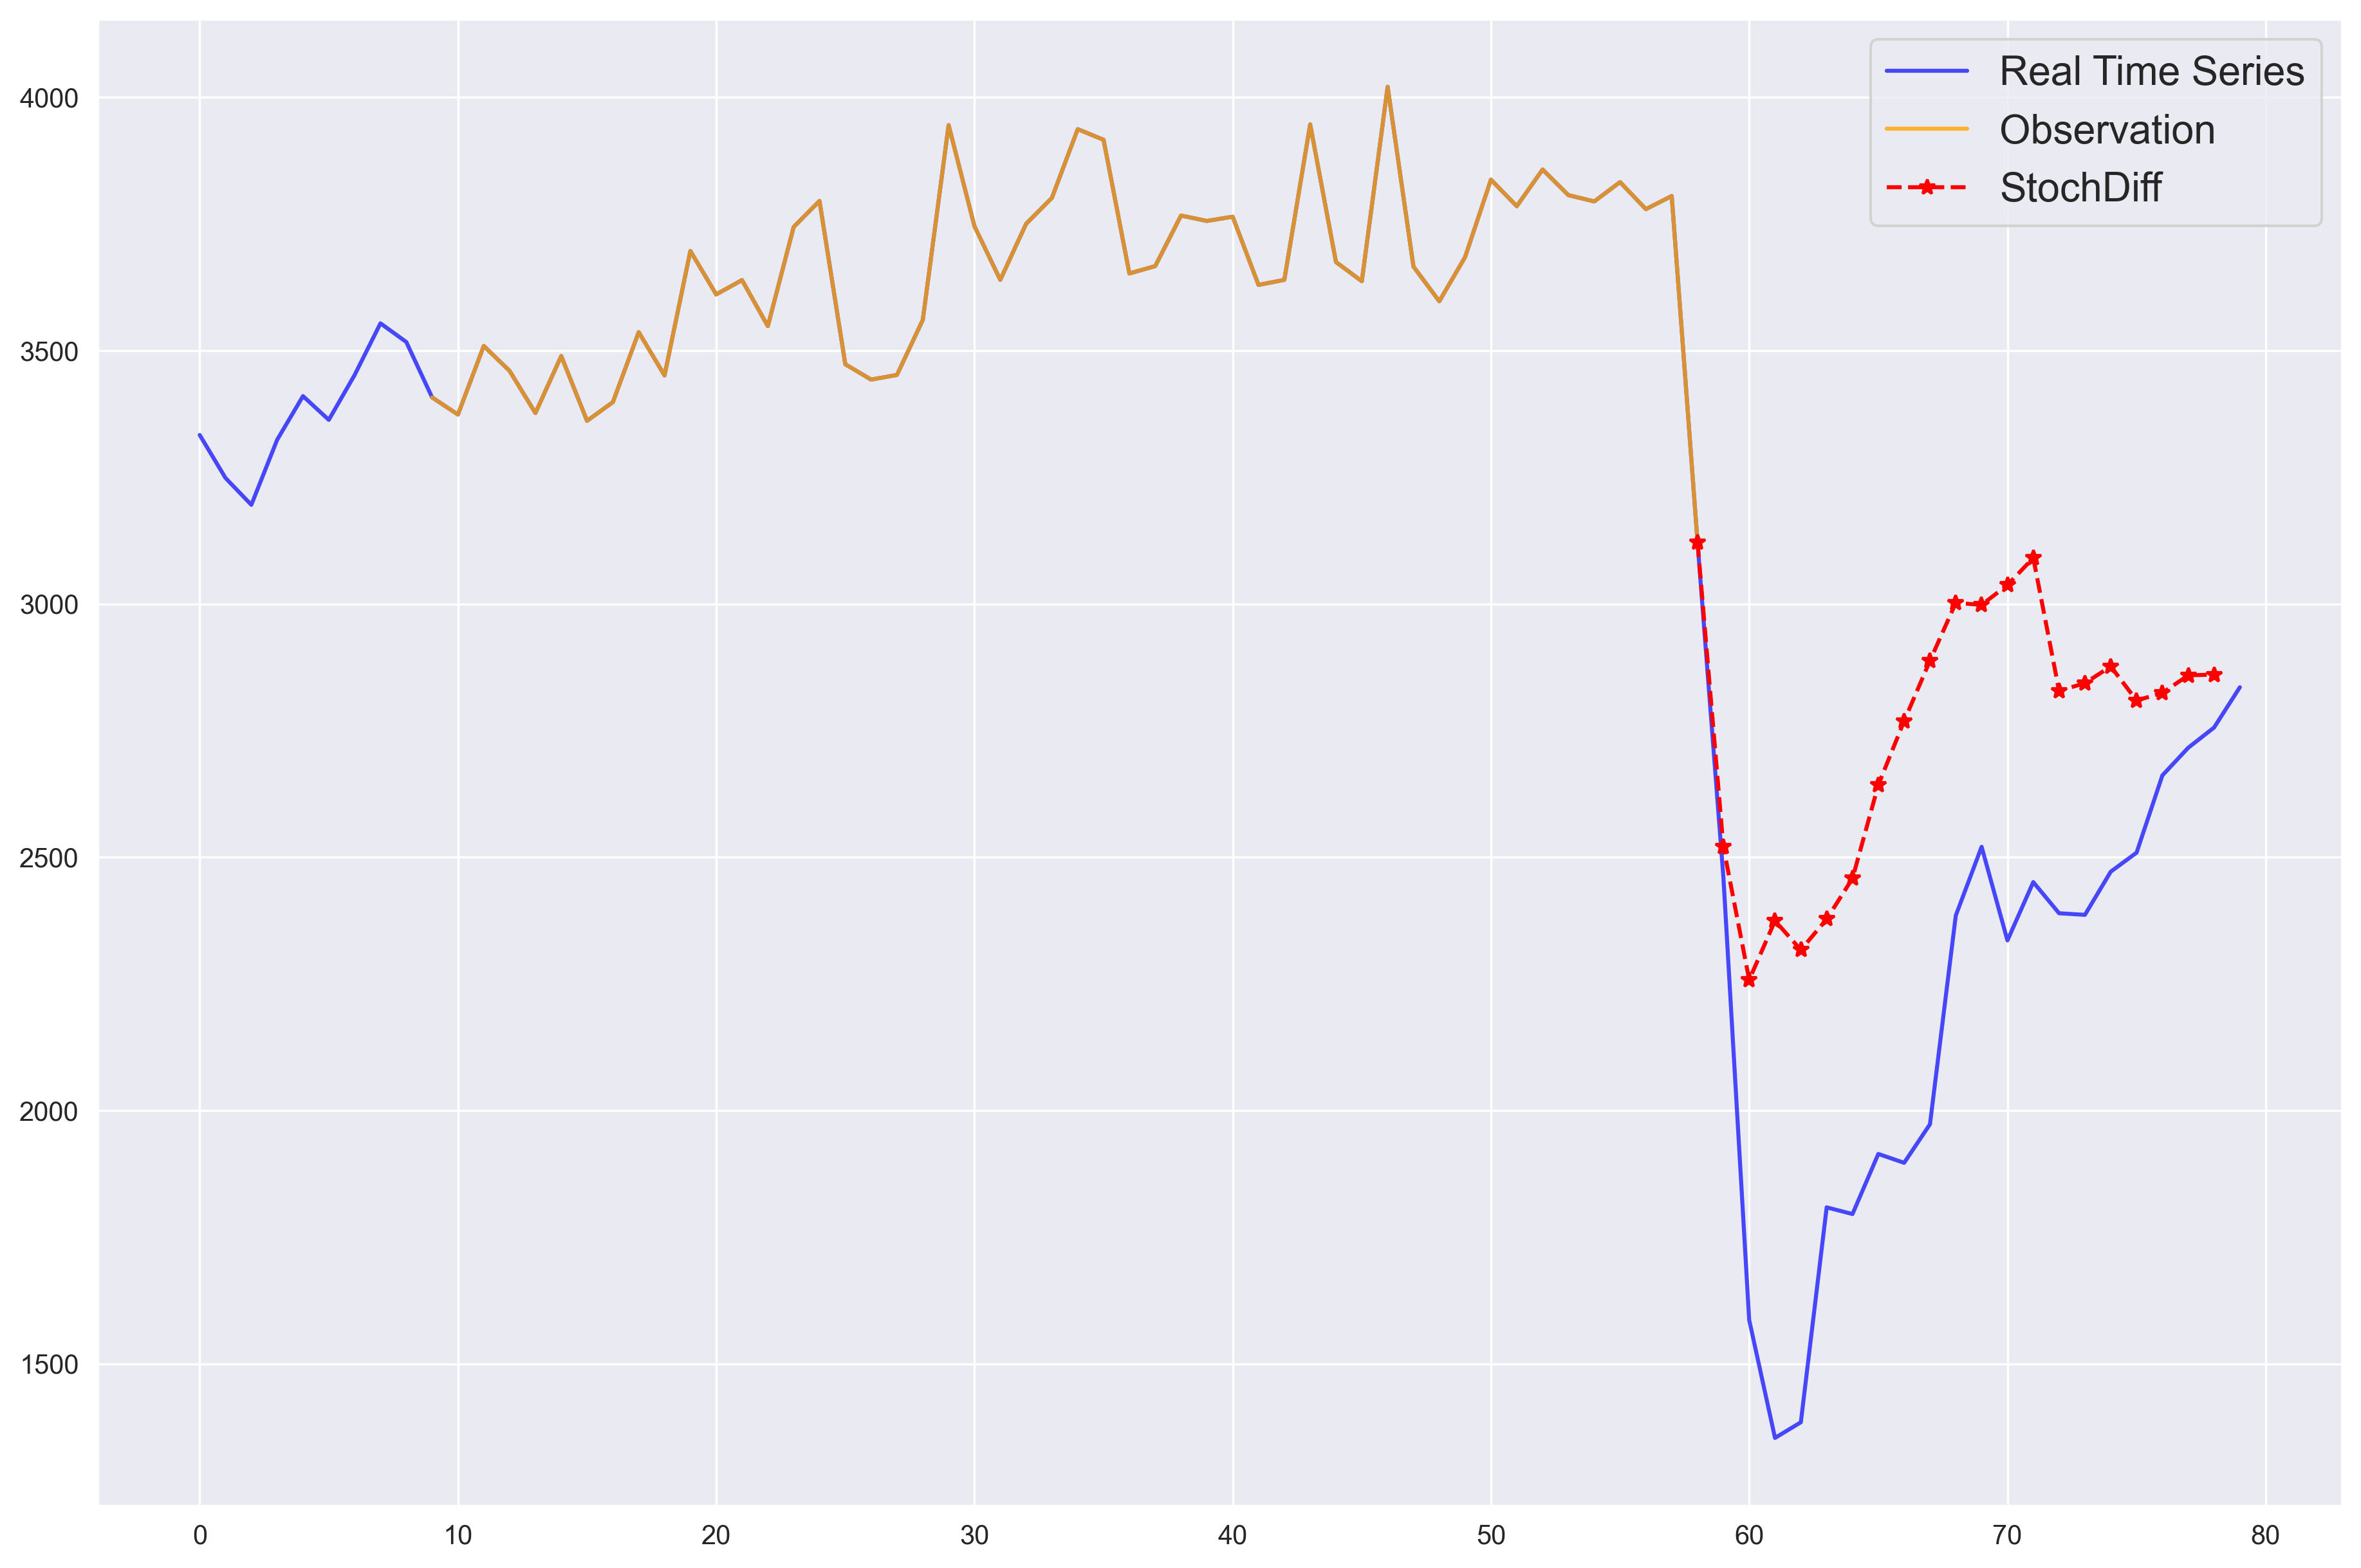

In [ ]:
# plot the result, follwoing the same behavior as in the paper (not exactly the same due to different random seeds)
sns.set_style("darkgrid", {'axes.grid': True})
fig, ax = plt.subplots(1,1,figsize=(15,10), dpi=300)
plt.plot(cm_raw, color = 'b', alpha=0.7, label='Real Time Series')
plt.plot(np.arange(9, 59), cm_sd[:50], color = 'orange', alpha = 0.8, label='Observation')
plt.plot(np.arange(58, 79), cm_sd[49:], color='red', marker='*', linestyle='--', label='StochDiff')
plt.legend(prop={'size':15})